<a href="https://colab.research.google.com/github/CasiCode/Star-Classification/blob/main/Star_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Рассмотрим задачу классификации небесных тел по отдельным данным о наблюдениях за ними.

Для начала импортируем все используемые далее библиотеки и модули:

In [3]:
import kagglehub
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

import os

from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import lightgbm as lgb

Скачаем датасет и получим путь до него через API Kaggle'а.

In [4]:
path = kagglehub.dataset_download("fedesoriano/stellar-classification-dataset-sdss17")
stars = pd.read_csv(f'{path}/star_classification.csv')

100%|██████████| 6.89M/6.89M [00:00<00:00, 95.0MB/s]

Extracting files...


Теперь можно приступить к EDA.

In [5]:
stars.shape

(100000, 18)

In [6]:
stars.head()

obj_ID       alpha      delta         u         g         r  \
0  1.237661e+18  135.689107  32.494632  23.87882  22.27530  20.39501   
1  1.237665e+18  144.826101  31.274185  24.77759  22.83188  22.58444   
2  1.237661e+18  142.188790  35.582444  25.26307  22.66389  20.60976   
3  1.237663e+18  338.741038  -0.402828  22.13682  23.77656  21.61162   
4  1.237680e+18  345.282593  21.183866  19.43718  17.58028  16.49747   

          i         z  run_ID  rerun_ID  cam_col  field_ID   spec_obj_ID  \
0  19.16573  18.79371    3606       301        2        79  6.543777e+18   
1  21.16812  21.61427    4518       301        5       119  1.176014e+19   
2  19.34857  18.94827    3606       301        2       120  5.152200e+18   
3  20.50454  19.25010    4192       301        3       214  1.030107e+19   
4  15.97711  15.54461    8102       301        3       137  6.891865e+18   

    class  redshift  plate    MJD  fiber_ID  
0  GALAXY  0.634794   5812  56354       171  
1  GALAXY  0.779136  10445  58158       427  
2  GALAXY  0.644195   4576  55592       299  
3  GALAXY  0.932346   9149  58039       775  
4  GALAXY  0.116123   6121  56187       842

In [7]:
stars.describe()

obj_ID          alpha          delta              u  \
count  1.000000e+05  100000.000000  100000.000000  100000.000000   
mean   1.237665e+18     177.629117      24.135305      21.980468   
std    8.438560e+12      96.502241      19.644665      31.769291   
min    1.237646e+18       0.005528     -18.785328   -9999.000000   
25%    1.237659e+18     127.518222       5.146771      20.352353   
50%    1.237663e+18     180.900700      23.645922      22.179135   
75%    1.237668e+18     233.895005      39.901550      23.687440   
max    1.237681e+18     359.999810      83.000519      32.781390   

                   g              r              i              z  \
count  100000.000000  100000.000000  100000.000000  100000.000000   
mean       20.531387      19.645762      19.084854      18.668810   
std        31.750292       1.854760       1.757895      31.728152   
min     -9999.000000       9.822070       9.469903   -9999.000000   
25%        18.965230      18.135828      17.732285      17.460677   
50%        21.099835      20.125290      19.405145      19.004595   
75%        22.123767      21.044785      20.396495      19.921120   
max        31.602240      29.571860      32.141470      29.383740   

              run_ID  rerun_ID        cam_col       field_ID   spec_obj_ID  \
count  100000.000000  100000.0  100000.000000  100000.000000  1.000000e+05   
mean     4481.366060     301.0       3.511610     186.130520  5.783882e+18   
std      1964.764593       0.0       1.586912     149.011073  3.324016e+18   
min       109.000000     301.0       1.000000      11.000000  2.995191e+17   
25%      3187.000000     301.0       2.000000      82.000000  2.844138e+18   
50%      4188.000000     301.0       4.000000     146.000000  5.614883e+18   
75%      5326.000000     301.0       5.000000     241.000000  8.332144e+18   
max      8162.000000     301.0       6.000000     989.000000  1.412694e+19   

            redshift          plate            MJD       fiber_ID  
count  100000.000000  100000.000000  100000.000000  100000.000000  
mean        0.576661    5137.009660   55588.647500     449.312740  
std         0.730707    2952.303351    1808.484233     272.498404  
min        -0.009971     266.000000   51608.000000       1.000000  
25%         0.054517    2526.000000   54234.000000     221.000000  
50%         0.424173    4987.000000   55868.500000     433.000000  
75%         0.704154    7400.250000   56777.000000     645.000000  
max         7.011245   12547.000000   58932.000000    1000.000000

Из таблицы выше видно, что у фичей u, g, z встречаются экстремально низкие одинаковые значения. Предположительно, данные значения являются способом обозначения пропусков в датасете.



Из таблицы также видно, что у всех числовых фичей кроме redshift, не отвечающих за обозначение id объектов, прослеживается нормальное распределение.

Отсечем выбросы по u, g, z, взяв объекты из выборки по нижним квантилям фичей.

In [8]:
u_lo = stars['u'].quantile(0.001)
g_lo = stars['g'].quantile(0.001)
z_lo = stars['z'].quantile(0.001)
stars_ = stars[(stars['u'] >= u_lo) & (stars['g'] >= g_lo) & (stars['z'] >= z_lo)]
stars_.shape

(99841, 18)

Теперь построим гистограммы распределения фичей:

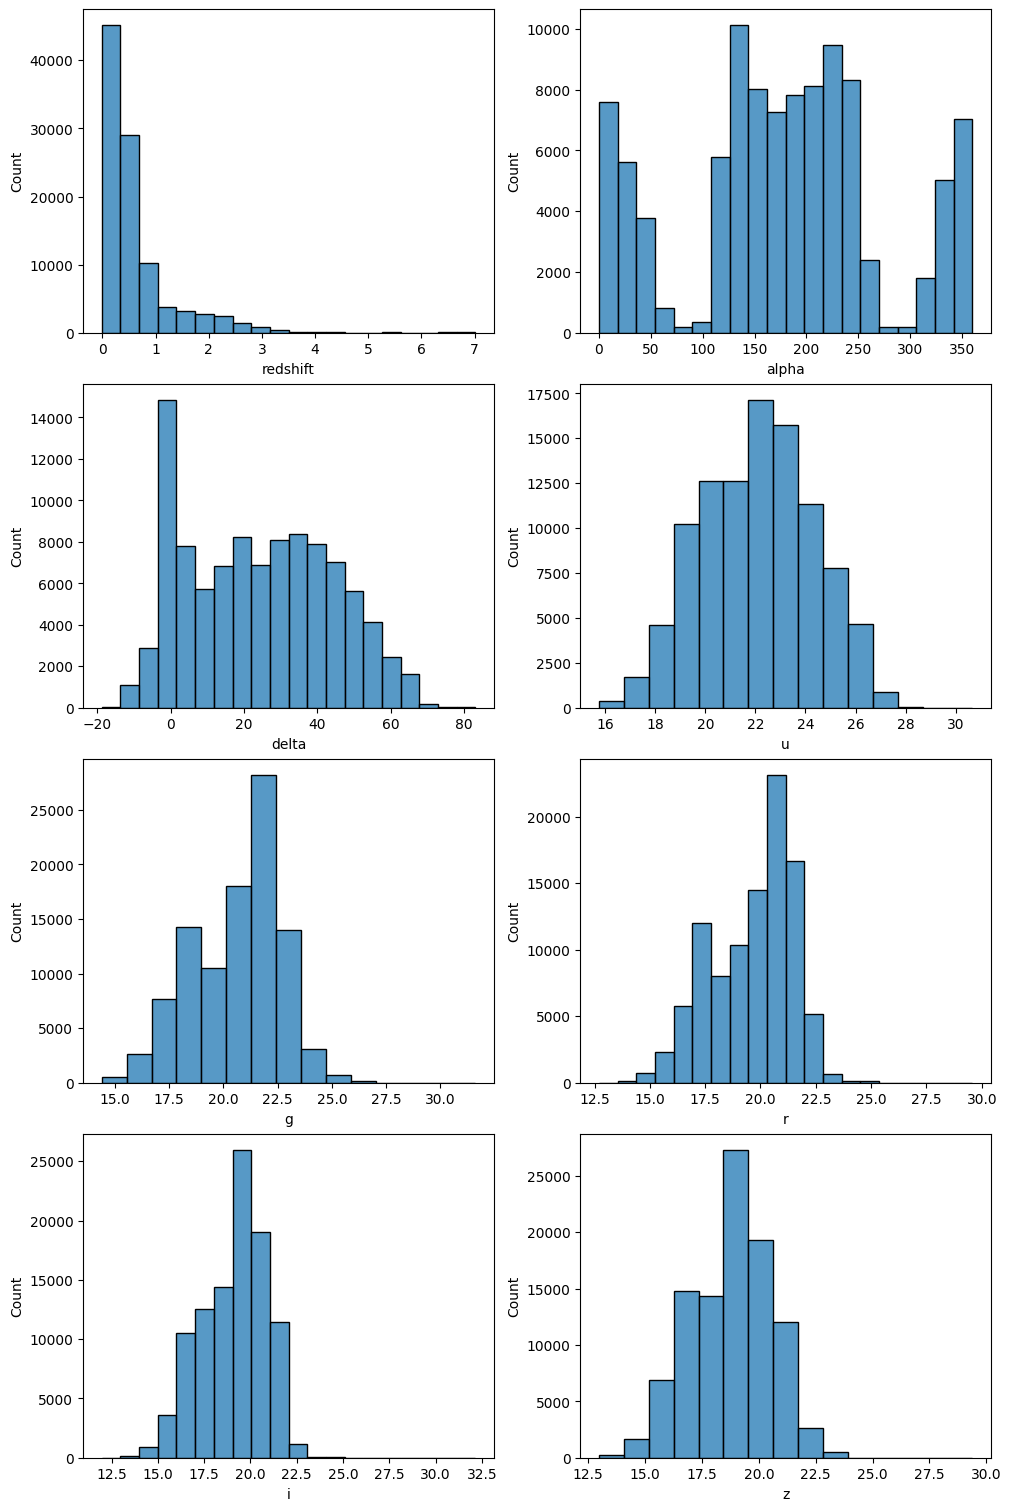

In [9]:
_, axs = plt.subplots(figsize=(10,15), nrows=4, ncols=2, layout='constrained')
sns.histplot(stars_.redshift, bins = 20, kde=False, ax=axs[0][0]);
sns.histplot(stars_.alpha, bins = 20, kde=False, ax=axs[0][1]);
sns.histplot(stars_.delta, bins = 20, kde=False, ax=axs[1][0]);
sns.histplot(stars_.u, bins = 15, kde=False, ax=axs[1][1]);
sns.histplot(stars_.g, bins = 15, kde=False, ax=axs[2][0]);
sns.histplot(stars_.r, bins = 20, kde=False, ax=axs[2][1]);
sns.histplot(stars_.i, bins = 20, kde=False, ax=axs[3][0]);
sns.histplot(stars_.z, bins = 15, kde=False, ax=axs[3][1]);

Как было сказано выше, все фичи имеют около-нормальное распределение. alpha - это угол поворота телескопа (из описания датасета на Kaggle), потому распределение по краям - у нуля и 360 в совокупности повторяет нормальное распределение в центре отрезка - у значения в 180 градусов.

Теперь построим ящики с усами:

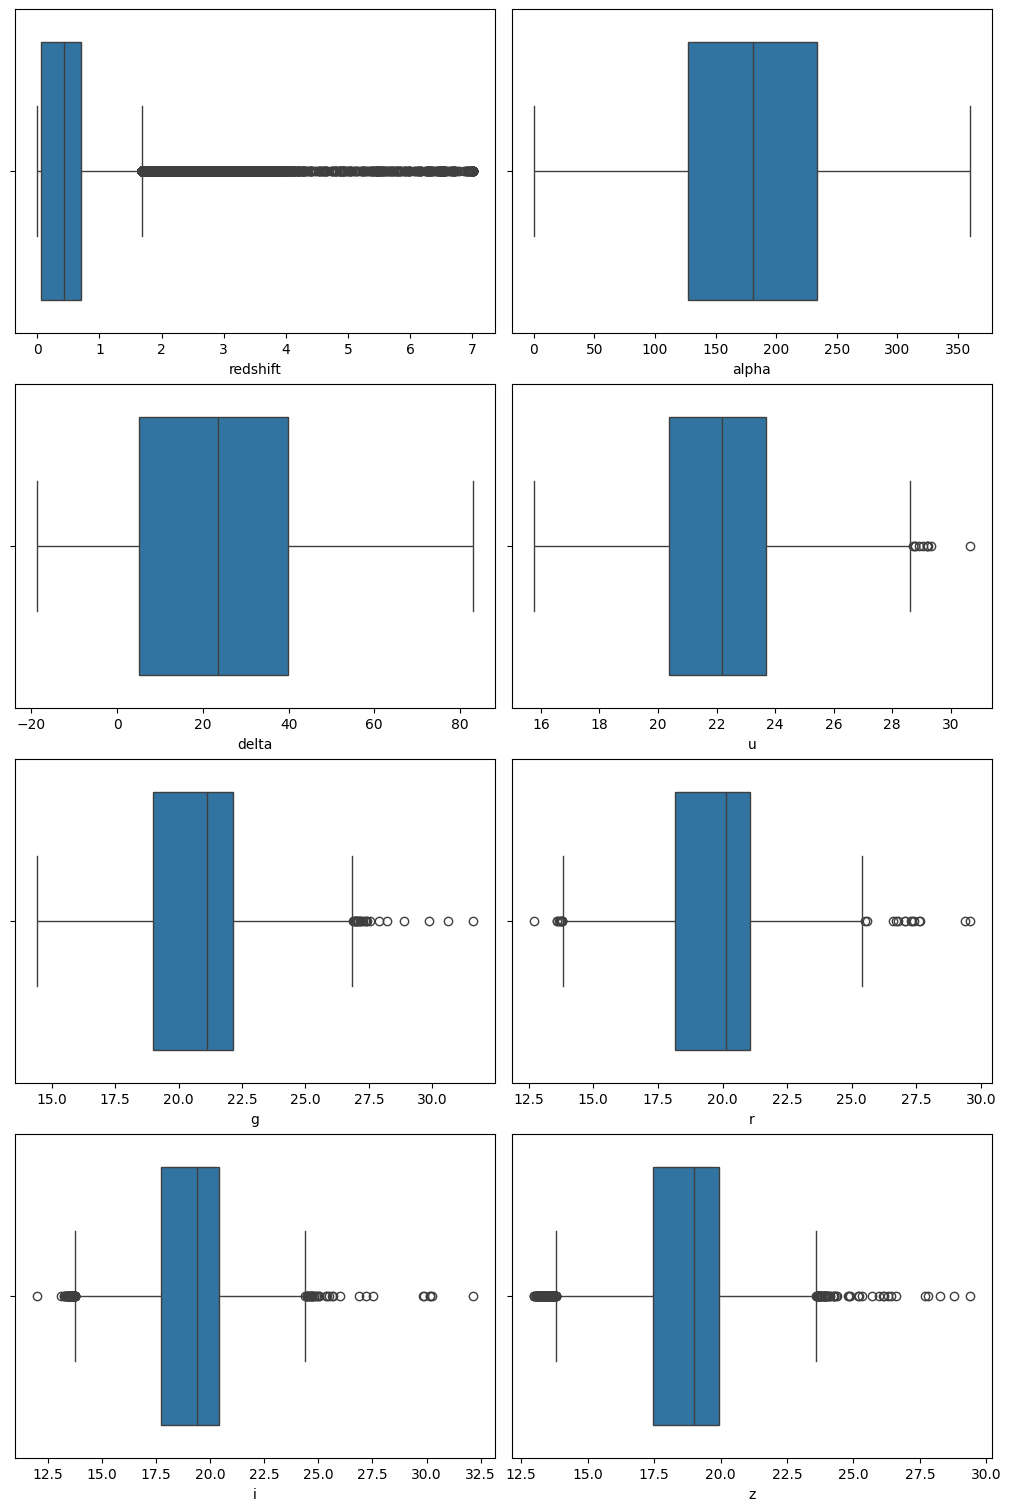

In [10]:
_, axs = plt.subplots(figsize=(10,15), nrows=4, ncols=2, layout='constrained')
sns.boxplot(data=stars_, x='redshift', ax = axs[0][0]);
sns.boxplot(data=stars_, x='alpha', ax = axs[0][1]);
sns.boxplot(data=stars_, x='delta', ax = axs[1][0]);
sns.boxplot(data=stars_, x='u', ax = axs[1][1]);
sns.boxplot(data=stars_, x='g', ax = axs[2][0]);
sns.boxplot(data=stars_, x='r', ax = axs[2][1]);
sns.boxplot(data=stars_, x='i', ax = axs[3][0]);
sns.boxplot(data=stars_, x='z', ax = axs[3][1]);

Из первого графика видно, что какой-то набор объектов обладает значениями фичи redshift, не попадающими в правый квантиль выборки. Примем их за выбросы. Кроме того, можно утверждать, что объекты со столь сильным красным смещением почти наверняка являются квазарами.

In [11]:
px.scatter(data_frame=stars_, x="alpha", y="delta", color='class')

Карта наблюдений. Опять прослеживается особенность alpha с "отзеркаленным" распределеним наблюдений.

Посмотрим, как расположены классы относительно красного смещения. Выведем график относительлно части спектра u. Забегая вперед, для других фичей, отвечающих за спектр, ситуация будет аналогичной

In [12]:
px.scatter(data_frame=stars_, x="redshift", y="u", color='class')

In [13]:
print(stars[stars['class'] == "GALAXY"].shape,
      stars[stars['class'] == "QSO"].shape,
      stars[stars['class'] == "STAR"].shape)

(59445, 18) (18961, 18) (21594, 18)


Видно, что выборка является несбалансированной. Отсюда следует, что нужно подобрать метрику пригодную для работы с несбалансированными классами.

In [14]:
list(stars)

['obj_ID',
 'alpha',
 'delta',
 'u',
 'g',
 'r',
 'i',
 'z',
 'run_ID',
 'rerun_ID',
 'cam_col',
 'field_ID',
 'spec_obj_ID',
 'class',
 'redshift',
 'plate',
 'MJD',
 'fiber_ID']

Дропнем айдишники и дату наблюдения, так как они никак не влияют на класс наблюдаемого объекта и вносят в датасет лишний шум. (Заодно вернемся к выборке без удаленных выбросов)

In [15]:
stars = stars.drop(columns=[
    'obj_ID', 'run_ID', 'rerun_ID', 'cam_col',
    'field_ID', 'spec_obj_ID', 'plate', 'fiber_ID', 'MJD'
])

In [16]:
stars.head()

alpha      delta         u         g         r         i         z  \
0  135.689107  32.494632  23.87882  22.27530  20.39501  19.16573  18.79371   
1  144.826101  31.274185  24.77759  22.83188  22.58444  21.16812  21.61427   
2  142.188790  35.582444  25.26307  22.66389  20.60976  19.34857  18.94827   
3  338.741038  -0.402828  22.13682  23.77656  21.61162  20.50454  19.25010   
4  345.282593  21.183866  19.43718  17.58028  16.49747  15.97711  15.54461   

    class  redshift  
0  GALAXY  0.634794  
1  GALAXY  0.779136  
2  GALAXY  0.644195  
3  GALAXY  0.932346  
4  GALAXY  0.116123

Модельку делать будем на LGBM. Он хорошо справляется с задачами мультиклассирования, в том числе на несбаллансированных датасетах, устойчив к мультиколлинеарности.

Разбиваем датасет на обучающую и тестовую выборки. Создаем фолды для кросс-валидации. Пробегаемся по ним по очереди и обучаем модельку, смотрим на результаты по обучающей выборке и OOF. В качестве метрики возьмем взвешенный F1-скор.

In [17]:
train, test = train_test_split(stars, test_size=0.2, random_state=51)
target = train['class'].values

cv = KFold(n_splits=5, random_state=100, shuffle=True)

trained = np.full(len(train), '', dtype=object)
oof = np.full(len(train), '', dtype=object)

model_parameters = {
    'objective': 'multiclass',
    'n_estimators': 200,
    'verbose': -1,
    'reg_alpha': 0.1,
    'reg_lambda': 0.1,
    'num_leaves': 31,
    'early_stopping_rounds': 25,
}

for fold_, (train_idx, val_idx) in enumerate(cv.split(train, target), 1):
    print(f'Training with fold {fold_} started')

    lgb_model = lgb.LGBMClassifier(**model_parameters)

    train_, val = train.iloc[train_idx].copy(), train.iloc[val_idx].copy()

    feat_cols = list(train.columns.values)
    feat_cols.remove('class')

    lgb_model.fit(train_[feat_cols], train_['class'],
                  eval_set=[(val[feat_cols], val['class'])])

    trained[train_idx] = lgb_model.predict(train_[feat_cols])
    oof[val_idx] = lgb_model.predict(val[feat_cols])

    print(f'Training with fold {fold_} completed\n')

print('Train: ', f1_score(target, trained, average='weighted'))
print('CV: ', f1_score(target, oof, average='weighted'))

Training with fold 1 started
Training with fold 1 completed

Training with fold 2 started
Training with fold 2 completed

Training with fold 3 started
Training with fold 3 completed

Training with fold 4 started
Training with fold 4 completed

Training with fold 5 started
Training with fold 5 completed

Train:  0.984936350527309
CV:  0.9774793721765688
